2024-02-12 14:26:33.471 | calibration.py:38 | WARNING: No module named 'pymoo'
Try running `pip install pymoo==0.6.0.1` to use all features in `fastsim.calibration`
2024-02-12 14:26:33.520 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.03157 exceeds tolerance of 0.00100
2024-02-12 14:26:33.521 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.97233 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 14:26:33.526 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.03036 exceeds tolerance of 0.00100
2024-02-12 14:26:33.526 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.95963 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 14:26:33.531 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.02927 exceeds tolerance of 0.00100
2024-02-12 14:26:33.531 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.94752 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 14:26:33.537 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.0282

Solving for fc_max_kw: 78.4
Solving for fc_max_kw: 82
Solving for fc_max_kw: 85.6
Solving for fc_max_kw: 89.2
Solving for fc_max_kw: 92.8
Solving for fc_max_kw: 96.5
Solving for fc_max_kw: 100
Solving for fc_max_kw: 104
Solving for fc_max_kw: 107
Solving for fc_max_kw: 111
Solving for fc_max_kw: 115
Solving for fc_max_kw: 118
Solving for fc_max_kw: 122
Solving for fc_max_kw: 125
Solving for fc_max_kw: 129
Solving for fc_max_kw: 133
Solving for fc_max_kw: 136
Solving for fc_max_kw: 140
Solving for fc_max_kw: 143
Solving for fc_max_kw: 147


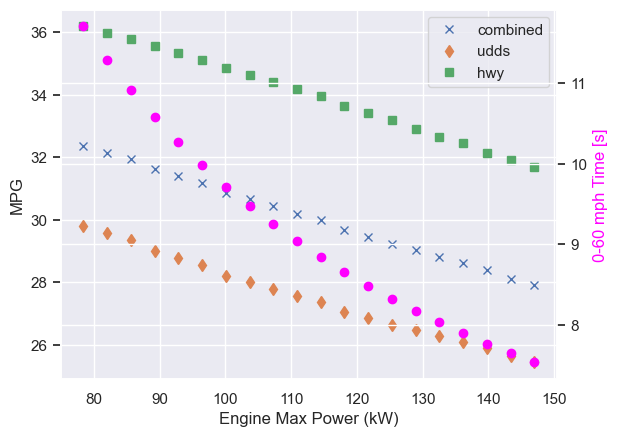

2024-02-12 14:26:33.896 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.02583 exceeds tolerance of 0.00100
2024-02-12 14:26:33.898 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.90390 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 14:26:33.904 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.02583 exceeds tolerance of 0.00100
2024-02-12 14:26:33.906 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.90390 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 14:26:33.914 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.02583 exceeds tolerance of 0.00100
2024-02-12 14:26:33.914 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.90390 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 14:26:33.919 | simdrive_impl.rs:1829 | WARNING: trace miss distance fraction 0.02583 exceeds tolerance of 0.00100
2024-02-12 14:26:33.920 | simdrive_impl.rs:1848 | WARNING: trace miss speed 39.90390 m/s exceeds tolerance of 1.00000 m/s
2024-02-12 1



*************************
Engine peak power that maximizes mpg with 0-60 mph time not exceeding 9 s:
112 kW


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# import fastsim
import fastsim as fsim
from fastsim import fsr

# build SimDriveLabel object for conventional vehicle
veh_base = fsim.vehicle.Vehicle.from_vehdb(1).to_rust()

# find optimum engine size subject to 0-60 mph constraint of 10 s and a fixed cost + linear cost per power 
# Via plotting

# create an array of possible engine (aka fuel converter (fc)) peak power
fc_max_kw_arr = np.linspace(0.8, 1.5, 20) * veh_base.fc_max_kw
# Initialize arrays for storing miles per gallon (mpg) results
mpg_hwy_arr = [] # highway
mpg_udds_arr = [] # city (udds = urban dynamometer driving schedule)
mpg_comb_arr = [] # combined
zero_to_sixty_arr = []


# i is a loop counter and `fc_max_kw` is the value at the index for that iteration
for i, fc_max_kw in enumerate(fc_max_kw_arr):
    print(f"Solving for fc_max_kw: {fc_max_kw:.3g}")
    veh = veh_base.copy()
    fsim.utils.set_attr_with_path(
        veh, # vehicle object
        "fc_max_kw", # vehicle attribute to set
        fc_max_kw, # new value
    )
    veh.set_derived()
    sdl: fsr.LabelFe = fsr.get_label_fe(veh)[0]
    mpg_comb_arr.append(sdl.adj_comb_mpgge)
    mpg_udds_arr.append(sdl.adj_udds_mpgge)
    mpg_hwy_arr.append(sdl.adj_hwy_mpgge)
    zero_to_sixty_arr.append(sdl.net_accel)

fig, ax = plt.subplots()
ax.plot(
    fc_max_kw_arr,
    mpg_comb_arr,
    linestyle="",
    marker='x',
    label='combined',
)
ax.plot(
    fc_max_kw_arr,
    mpg_udds_arr,
    linestyle="",
    marker='d',
    label='udds',
)
ax.plot(
    fc_max_kw_arr,
    mpg_hwy_arr,
    linestyle="",
    marker='s',
    label='hwy',
)
ax.set_xlabel('Engine Max Power (kW)')
ax.set_ylabel("MPG")
ax.legend()

mpg_color = 'magenta'
ax2 = ax.twinx()
ax2.plot(
    fc_max_kw_arr,
    zero_to_sixty_arr,
    linestyle="",
    marker='o',
    color=mpg_color
)
ax2.set_ylabel("0-60 mph Time [s]", color=mpg_color)

plt.show()

# Via scipy optimize with 0-60 mph time constraint

def get_combined_mpg(
    fc_max_kw: float
) -> float:

    veh = veh_base.copy()
    fsim.utils.set_attr_with_path(
        veh, # vehicle object
        "fc_max_kw", # vehicle attribute to set
        fc_max_kw, # new value
    )
    veh.set_derived()
    sdl: fsr.LabelFe = fsr.get_label_fe(veh)[0]
    return sdl.adj_comb_mpgge, sdl.net_accel


def obj_fun(fc_max_kw: float) -> float:
    return -get_combined_mpg(fc_max_kw)[0]

# maximum allowable zero-to-sixty time [s]
max_zero_to_sixty = 9.0

def constraint_fun(fc_max_kw: float) -> float:
    return max_zero_to_sixty - get_combined_mpg(fc_max_kw)[1]

constraints = {'type': 'ineq', 'fun': constraint_fun}
bounds = [(50, 150)]

fc_max_kw_best_mpg = minimize(
    obj_fun,
    100.0, # initial guess
    bounds=bounds,
    constraints=constraints
)

print('\n')
print("*"*25)
print(f"Engine peak power that maximizes mpg with 0-60 mph time not exceeding 9 s:\n{fc_max_kw_best_mpg.x[0]:.3g} kW")


# Plot time traces of selected design